## Original Model

In [77]:
import numpy as np
import torch
import os

In [78]:
if not os.path.exists('facial_keypoints.npz'):
  !wget -O facial_keypoints.npz "https://www.dropbox.com/scl/fi/27qggijmythfjg04s24xq/facial_keypoints.npz?rlkey=h91gwodhrfuz8hrc7ux9qnq7s&dl=1"

(7049, 1, 96, 96) int64 0 255
(7049, 30) float32 0.686592 95.935646


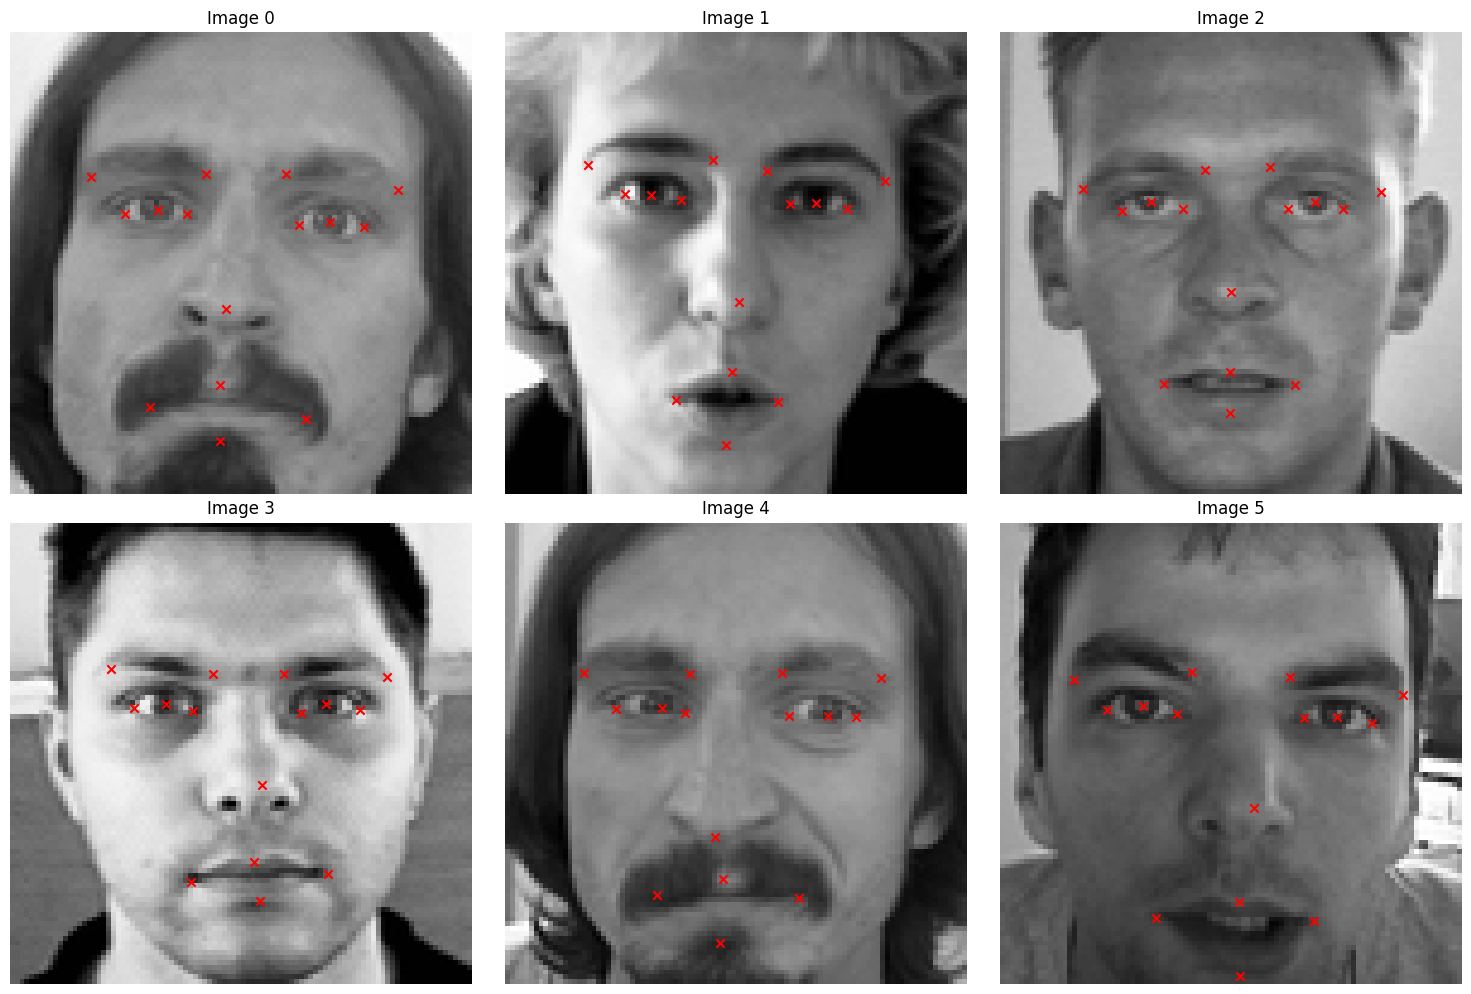

In [79]:
data = np.load('facial_keypoints.npz')
images = data['images']
keypoints = data['keypoints']

print(images.shape, images.dtype, np.nanmin(images), np.nanmax(images))
print(keypoints.shape, keypoints.dtype, np.nanmin(keypoints), np.nanmax(keypoints))

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(6):
    # Each image has shape (1, 96, 96)
    # now shape is (96, 96) because removing the first dimension
    image = images[i].squeeze()  
    
    # reshape into 15 (x,y) pairs
    pts = keypoints[i].reshape(-1, 2)
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap='gray')
    
    for (x, y) in pts:
        if np.isnan(x) or np.isnan(y):
            continue
        plt.scatter(x, y, marker='x', color='red')
    
    plt.title(f'Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split the data into 90% training and 10% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, keypoints, test_size=0.1, random_state=42
)

# Preprocess images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)


print("X_train shape:", X_train.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("Keypoints training range per feature (ignoring NaNs):")
print("Min values:", np.nanmin(y_train_scaled, axis=0))
print("Max values:", np.nanmax(y_train_scaled, axis=0))

X_train shape: (6344, 1, 96, 96)
y_train_scaled shape: (6344, 30)
Keypoints training range per feature (ignoring NaNs):
Min values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Max values: [1.         0.9999999  1.0000001  1.         1.         0.99999994
 1.         1.         0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         1.         0.9999999
 1.         1.         1.         1.0000001  1.0000001  0.9999999 ]


In [81]:
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# TensorDataset objects for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader objects to iterate through the dataset in batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print out the number of batches in each DataLoader for verification
print("Number of batches in training set:", len(train_loader))
print("Number of batches in testing set:", len(test_loader))

Number of batches in training set: 100
Number of batches in testing set: 12


In [82]:
import torch.nn as nn
import torch.nn.functional as F

class FacialKeypointsCNN(nn.Module):
    def __init__(self):
        super(FacialKeypointsCNN, self).__init__()
        # Two convolutional layers followed by max pooling.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(16 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 30)  # 30 outputs for 15 (x,y) keypoints
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [83]:
import torch.optim as optim

def masked_mse_loss(y_pred, y_true):
    # boolean mask where values are valid
    mask = ~torch.isnan(y_true)
    # squared error only for valid entries
    return ((y_pred[mask] - y_true[mask])**2).mean()

class SmallFacialKeypointsCNN(nn.Module):
    def __init__(self):
        super(SmallFacialKeypointsCNN, self).__init__()
        # two conv layers followed by max pooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers:
        self.fc1 = nn.Linear(16 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 30)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if MPS is available and use it as the device if possible
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# move it to the device
model = SmallFacialKeypointsCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, keypoints) in enumerate(train_loader):
        # Move data to the device    
        images = images.to(device)
        keypoints = keypoints.to(device)
        optimizer.zero_grad()     
        outputs = model(images)

        loss = masked_mse_loss(outputs, keypoints)
        loss.backward()            
        optimizer.step()         
        
        running_loss += loss.item()
        
        # printing every 10 batches
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    avg_loss = running_loss / len(train_loader)
    print(f'==> Epoch [{epoch+1}] completed. Average Loss: {avg_loss:.4f}')

Using device: mps
Epoch [1/10], Batch [10/100], Loss: 0.0640
Epoch [1/10], Batch [20/100], Loss: 0.0175
Epoch [1/10], Batch [30/100], Loss: 0.0081
Epoch [1/10], Batch [40/100], Loss: 0.0063
Epoch [1/10], Batch [50/100], Loss: 0.0040
Epoch [1/10], Batch [60/100], Loss: 0.0046
Epoch [1/10], Batch [70/100], Loss: 0.0039
Epoch [1/10], Batch [80/100], Loss: 0.0039
Epoch [1/10], Batch [90/100], Loss: 0.0034
Epoch [1/10], Batch [100/100], Loss: 0.0047
==> Epoch [1] completed. Average Loss: 0.0333
Epoch [2/10], Batch [10/100], Loss: 0.0043
Epoch [2/10], Batch [20/100], Loss: 0.0054
Epoch [2/10], Batch [30/100], Loss: 0.0027
Epoch [2/10], Batch [40/100], Loss: 0.0035
Epoch [2/10], Batch [50/100], Loss: 0.0040
Epoch [2/10], Batch [60/100], Loss: 0.0031
Epoch [2/10], Batch [70/100], Loss: 0.0027
Epoch [2/10], Batch [80/100], Loss: 0.0049
Epoch [2/10], Batch [90/100], Loss: 0.0037
Epoch [2/10], Batch [100/100], Loss: 0.0034
==> Epoch [2] completed. Average Loss: 0.0040
Epoch [3/10], Batch [10/100]

In [84]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, keypoints in test_loader:
        images = images.to(device)
        keypoints = keypoints.to(device)
        preds = model(images)
        # convert to numpy arrays
        all_preds.append(preds.cpu().numpy())
        all_targets.append(keypoints.cpu().numpy())

# combine all predictions and targets into single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# converting normalized predictions back to pixel units.
all_preds_pixels = scaler.inverse_transform(all_preds)
all_targets_pixels = scaler.inverse_transform(all_targets)

# computing error metrics in pixel units.
mse_pixels = np.nanmean((all_preds_pixels - all_targets_pixels) ** 2)
rmse_pixels = np.sqrt(mse_pixels)
print("Pixel Units Test RMSE: {:.2f}".format(rmse_pixels))

Pixel Units Test RMSE: 2.80


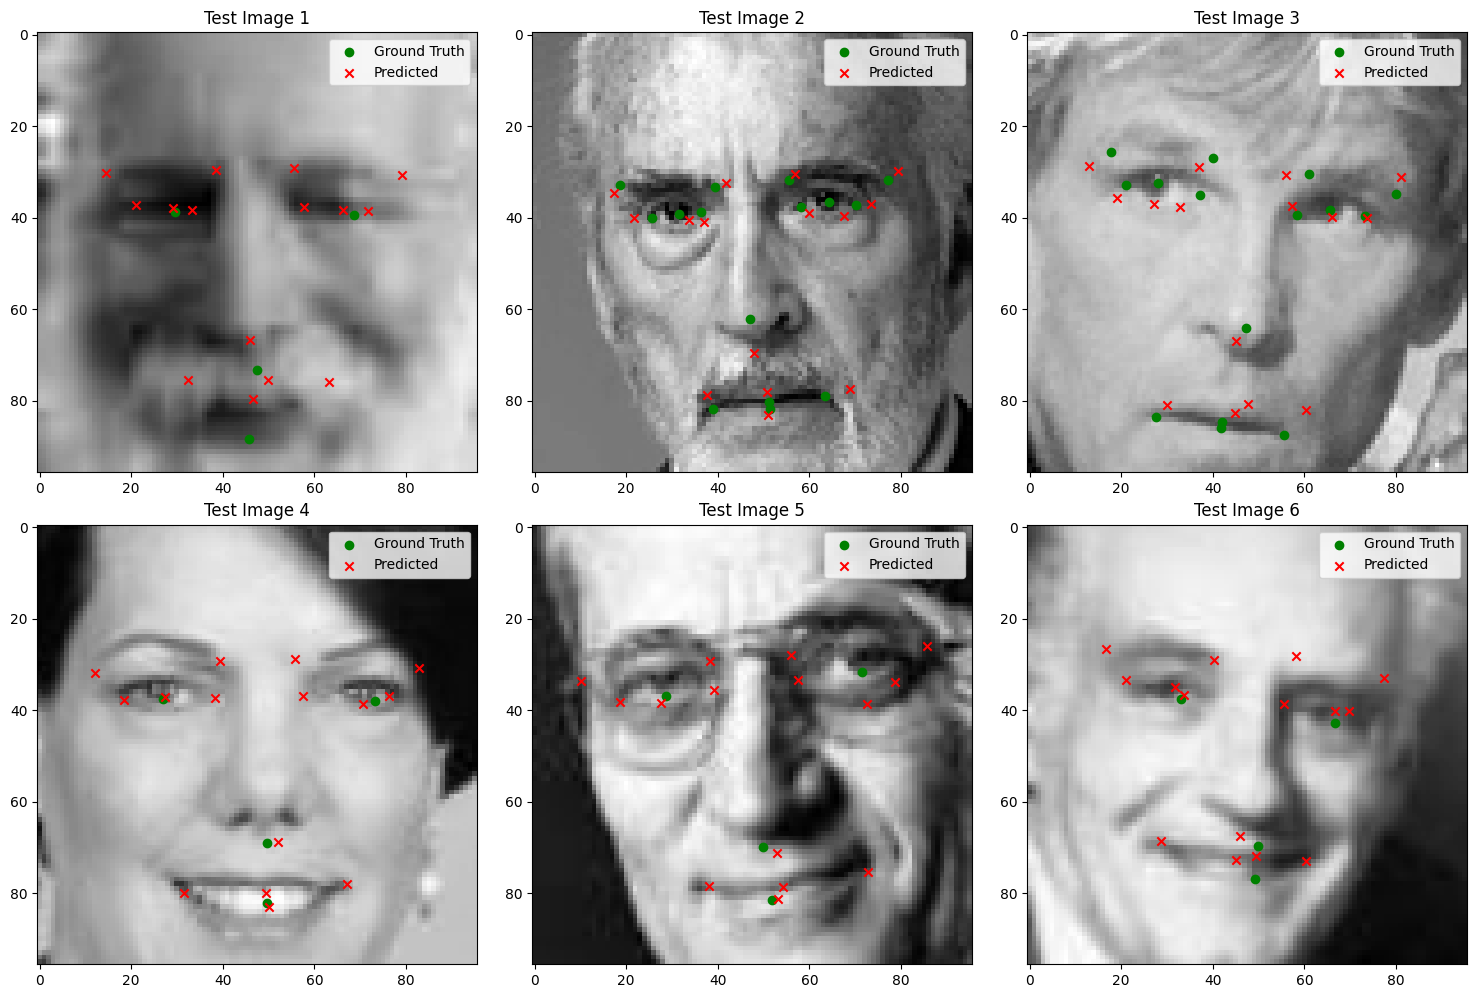

In [85]:
num_images_to_plot = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plotted = 0
for images, keypoints in test_loader:
    if plotted >= num_images_to_plot:
        break

    image = images[0]
    keypoints_norm = keypoints[0]
    
    # converting the image to a 2D numpy array for plotting
    image_np = image.squeeze().cpu().numpy()

    # inverse-transform the keypoints to pixel units.
    keypoints_pixels = scaler.inverse_transform(keypoints_norm.cpu().numpy().reshape(1, -1)).reshape(-1, 2)

    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_input)
    pred_pixels = scaler.inverse_transform(pred[0].cpu().numpy().reshape(1, -1)).reshape(-1, 2)

    ax = axes[plotted]
    ax.imshow(image_np, cmap='gray')
    ax.scatter(keypoints_pixels[:, 0], keypoints_pixels[:, 1],
               c='green', marker='o', label='Ground Truth')
    ax.scatter(pred_pixels[:, 0], pred_pixels[:, 1],
               c='red', marker='x', label='Predicted')
    ax.set_title(f'Test Image {plotted+1}')
    ax.legend()
    plotted += 1

plt.tight_layout()
plt.show()

## Improved Model
- Using data augmentation such as horizontal flips, rotations, scaling, and shifts. These are applied to the images and the keypoints.
- Also using batch normalization layers and a bigger architecture with more filters.

In [86]:
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch.utils.data import Dataset

In [87]:
# custom dataset class for transforming images and keypoints
class FacialKeypointsDataset(Dataset):
    def __init__(self, images, keypoints, transform=None):
        self.images = images
        self.keypoints = keypoints
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].squeeze()
        image = image[..., None]
        keypoints = self.keypoints[idx].reshape(-1, 2).astype(np.float32) / 96.0
        
        if self.transform:
            augmented = self.transform(image=image, keypoints=keypoints)
            image = augmented['image']
            keypoints = augmented['keypoints']
            keypoints = torch.tensor(keypoints, dtype=torch.float32).view(-1)
        else:
            image = ToTensorV2()(image=image)['image']
            keypoints = torch.tensor(keypoints, dtype=torch.float32).view(-1)
        
        return image, keypoints

# Training augmentations: horizontal flip, random rotation, shift/scale/rotate, normalization
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# For testing/validation, only normalization:
test_transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

/Users/ishaansathaye/Git/CalPolyCourses/CSC487-DeepLearning/env/lib/python3.10/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/Users/ishaansathaye/Git/CalPolyCourses/CSC487-DeepLearning/env/lib/python3.10/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


In [88]:
train_dataset = FacialKeypointsDataset(X_train, y_train, transform=None)
test_dataset  = FacialKeypointsDataset(X_test, y_test, transform=None)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Improved CNN with batch normalization and dropout
class ImprovedFacialKeypointsCNN(nn.Module):
    def __init__(self):
        super(ImprovedFacialKeypointsCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5   = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 30)  # Output: 30 keypoint coordinates
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [89]:
# Check if MPS is available and use it as the device if possible
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = ImprovedFacialKeypointsCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom loss function that ignores NaN values
def masked_mse_loss(y_pred, y_true):
    # Only compute loss on valid (non-NaN) keypoints.
    mask = ~torch.isnan(y_true)
    return ((y_pred[mask] - y_true[mask]) ** 2).mean()

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, keypoints) in enumerate(train_loader):
        images = images.to(device)
        keypoints = keypoints.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_mse_loss(outputs, keypoints)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(train_loader)
    print(f"==> Epoch [{epoch+1}] completed. Average Loss: {epoch_loss:.4f}")

Using device: mps
Epoch [1/10], Batch [10/100], Loss: 0.3174
Epoch [1/10], Batch [20/100], Loss: 0.2278
Epoch [1/10], Batch [30/100], Loss: 0.1551
Epoch [1/10], Batch [40/100], Loss: 0.1368
Epoch [1/10], Batch [50/100], Loss: 0.1063
Epoch [1/10], Batch [60/100], Loss: 0.0856
Epoch [1/10], Batch [70/100], Loss: 0.1093
Epoch [1/10], Batch [80/100], Loss: 0.1174
Epoch [1/10], Batch [90/100], Loss: 0.0927
Epoch [1/10], Batch [100/100], Loss: 0.0466
==> Epoch [1] completed. Average Loss: 3.0498
Epoch [2/10], Batch [10/100], Loss: 0.0895
Epoch [2/10], Batch [20/100], Loss: 0.0639
Epoch [2/10], Batch [30/100], Loss: 0.0667
Epoch [2/10], Batch [40/100], Loss: 0.0697
Epoch [2/10], Batch [50/100], Loss: 0.0750
Epoch [2/10], Batch [60/100], Loss: 0.0440
Epoch [2/10], Batch [70/100], Loss: 0.0657
Epoch [2/10], Batch [80/100], Loss: 0.0752
Epoch [2/10], Batch [90/100], Loss: 0.0626
Epoch [2/10], Batch [100/100], Loss: 0.1073
==> Epoch [2] completed. Average Loss: 0.0708
Epoch [3/10], Batch [10/100]

In [90]:
import numpy as np
import torch

model.eval()  # Set model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for images, keypoints in test_loader:
        images = images.to(device)
        keypoints = keypoints.to(device)
        preds = model(images)
        # back to pixel units
        all_preds.append((preds.cpu().numpy() * 96.0))
        all_targets.append((keypoints.cpu().numpy() * 96.0))

# Combine all predictions and targets into single arrays
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
mse_pixels = np.nanmean((all_preds - all_targets) ** 2)
rmse_pixels = np.sqrt(mse_pixels)
print("Test RMSE (in pixel units): {:.2f}".format(rmse_pixels))

Test RMSE (in pixel units): 5.18


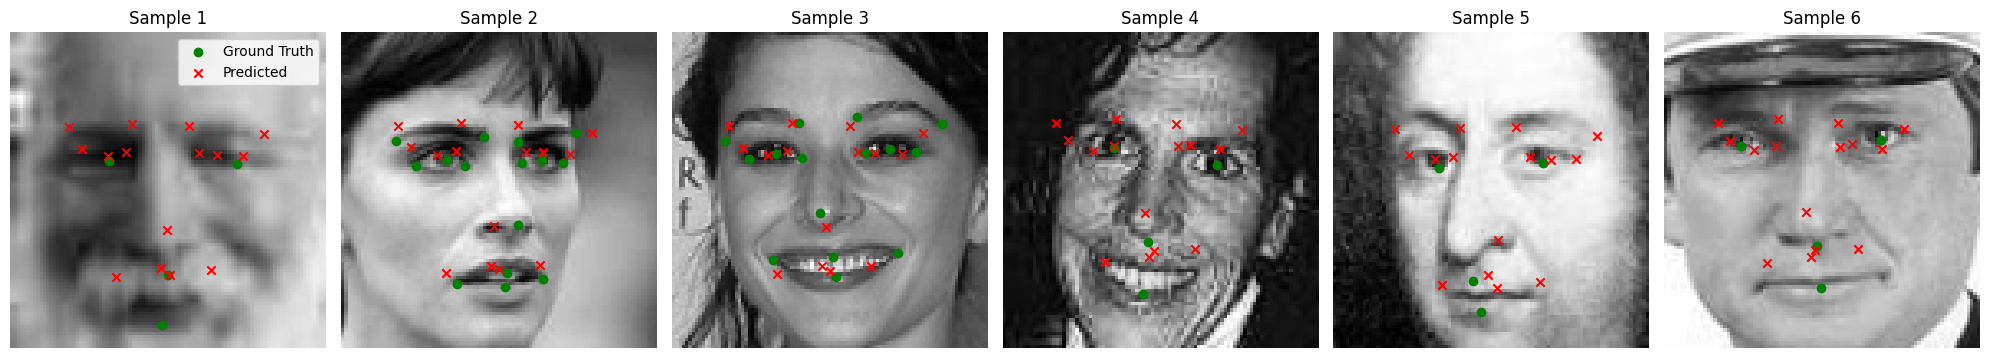

In [91]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader, num_images=6):
    model.eval()
    images_plotted = 0
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    
    with torch.no_grad():
        for images, keypoints in data_loader:
            images = images.to(device)
            preds = model(images)
            preds_pixels = preds.cpu().numpy() * 96.0
            keypoints_pixels = keypoints.cpu().numpy() * 96.0
            
            batch_size = images.shape[0]
            for i in range(batch_size):
                if images_plotted >= num_images:
                    break
                img = images[i].cpu().squeeze().numpy()
                gt = keypoints_pixels[i].reshape(-1, 2)
                pr = preds_pixels[i].reshape(-1, 2)
                
                ax = axes[images_plotted]
                ax.imshow(img, cmap='gray')
                ax.scatter(gt[:, 0], gt[:, 1], c='g', marker='o', label='Ground Truth')
                ax.scatter(pr[:, 0], pr[:, 1], c='r', marker='x', label='Predicted')
                ax.set_title(f"Sample {images_plotted+1}")
                ax.axis('off')
                if images_plotted == 0:
                    ax.legend()
                images_plotted += 1
            if images_plotted >= num_images:
                break
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader, num_images=6)